In [1]:
#import relevant libraries 
import pandas as pd
import plotly.express as px
import panel as pn
import hvplot.pandas
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
import os
%matplotlib inline
import nltk
nltk.download('vader_lexicon')
from datetime import datetime, timedelta,date
from pandas import DataFrame
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

#import hvplot.streamz
#from streamz import Stream
#from streamz.dataframe import DataFrame

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/anna/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
## Get Covid Case Count Data
#using url for covid 19 api united states case counts confirmed
request_url = "https://api.covid19api.com/total/dayone/country/united-states/status/confirmed"

def get_case_count(request_url):
    # Submit request and format output
    response_data = requests.get(request_url).json()
    states_json = json.dumps(response_data, indent=4)
    case_count_df = pd.read_json(request_url)
    #clean data
    case_count_df.drop(columns = ['CountryCode', 'Province', 'City', 'CityCode', 'Lat','Lon'], inplace = True)
    #update date time stamp to just date
    case_count_df['Date']=case_count_df['Date'].dt.date
    case_count_df.set_index('Date', inplace = True)
    #add percent change column
    case_pct_change = case_count_df['Cases'].pct_change()
    case_count_df['Pct_Change']= case_pct_change
    #add 7 day rolling moving average
    case_rolling = case_count_df['Cases'].rolling(window = 7).mean()
    case_count_df['7day_Rolling'] = case_rolling
    #drop nulls
    case_count_df.dropna(inplace = True)
    return case_count_df

In [3]:
case_count_df=get_case_count(request_url)


In [4]:
## Get Covid 19 News Data
# Read api key environment variable for news api
load_dotenv()
newsapi_key = os.getenv("newsapikey")

import newsapi
from newsapi import NewsApiClient

#get news articles on covid 19
# Create a newsapi client
newsapi = NewsApiClient(api_key=newsapi_key)
    
    

In [5]:
## Get Market Data for S&P500 
#engage API keys by activating .env file for Alpaca Api
load_dotenv()
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

def get_SP500_data(api):
    #load in historical data for S&P 500
    sp500_df = api.alpha_vantage.historic_quotes('SPY', adjusted=True, output_format='pandas')
    
    #Clean Data
    #Select the column we need,  "adjusted close", and drop the others
    sp500_df = sp500_df['5. adjusted close']
    #Sort earliest to latest so that .pct_change() function works right.
    sp500_df.sort_index(inplace=True, ascending=True)

    #create a dataframe column for the daily returns (pct_change) values and concat with SP500 close
    returns_df = sp500_df.pct_change()
    all_returns_df = pd.concat([sp500_df, returns_df], axis="columns", join="inner")

    #Change column names to avoid confusion
    columns = ['S&P 500 close','S&P 500 Daily Returns']
    all_returns_df.columns = columns

    # Drop nulls
    all_returns_df.dropna(inplace=True)

    #drop duplicates
    all_returns_df.drop_duplicates(inplace=True) 
    return all_returns_df

In [6]:
all_returns_df=get_SP500_data(api)

In [7]:
def exp_moving_avg():
    return 

In [8]:
def bolinger_bands():
    return

In [45]:
def covid_case_count(case_count_df):
    case_count_signals_df = case_count_df.loc[:, ['Cases']].copy()
    short_window = 7
    long_window = 30

    case_count_signals_df['7day % Change'] = case_count_signals_df['Cases'].pct_change().rolling(short_window).mean()
    case_count_signals_df['30day % Change'] = case_count_signals_df['Cases'].pct_change().rolling(long_window).mean()

    case_count_signals_df['Case Count Signal'] = 0.0
    case_count_signals_df['Case Count Signal'][short_window:] = np.where(case_count_signals_df['7day % Change'][short_window:] > case_count_signals_df['30day % Change'][short_window:], 1.0, -1.0)
    case_count_signals_df['Case Entry/Exit']=case_count_signals_df['Case Count Signal'].diff()
    return case_count_signals_df
    

In [32]:
def covid_sentiment(newsapi):
    daily_signal_dict={}
    daily_sentiment_dict={}

    for i in range(30):

        # Set start and end datetimes of for 1 days of news
        end_date = datetime.now()
        start_date = end_date + timedelta(-i)
        end_date=end_date.strftime("%Y-%m-%d")
        start_date=start_date.strftime("%Y-%m-%d")

        # Fetch the Covid19 news articles
        covid19_news = newsapi.get_everything(
        from_param=start_date,
        to=end_date,
        q="Covid 19",
        language="en",
        page_size=100,
        sort_by="relevancy"
        )
    

        #covid-19 sentiment list to dataframe
        covid19_sentiment_list=[]
        for article in covid19_news["articles"]:        
            try: 
                text = article["content"]
                sentiment = analyzer.polarity_scores(text)
                compound = sentiment["compound"]
                pos = sentiment["pos"]
                neu = sentiment["neu"]
                neg = sentiment["neg"]
                scores={"Compound":compound, "Negative":neg, "Neutral":neu, "Positive":pos, "text":text}
                covid19_sentiment_list.append(scores)
        
            except: 
                pass

        covid19_sentiment_df=pd.DataFrame(covid19_sentiment_list)
    

        # Describe the  Sentiment Related to Covid19/Coronavirus
        sentiment_df=covid19_sentiment_df.describe()


        #determine trading signal value based on covid news sentiment 
        if sentiment_df['Neutral'][1] > (sentiment_df['Positive'][1] and sentiment_df['Negative'][1]):
            sentiment_signal=0.0
            sentiment='Neutral'
        elif sentiment_df['Negative'][1] > (sentiment_df['Positive'][1] and sentiment_df['Neutral'][1]):
            sentiment_signal=-1.0
            sentiment='Negative'
        elif sentiment_df['Positive'][1] > (sentiment_df['Negative'][1] and sentiment_df['Netural'][1]):
            sentiment_signal=1.0
            sentiment='Positive'

        daily_signal_dict.update({start_date:sentiment_signal})
        daily_sentiment_dict.update({start_date:sentiment})
   
    #convert dictionary to dataframe     
    daily_signal_df=DataFrame.from_dict(daily_signal_dict,orient='index',columns=['Sentiment Signal'])
    daily_sentiment_df=DataFrame.from_dict(daily_sentiment_dict,orient='index',columns=['Sentiment'])

    sentiment_signal_df=pd.concat([daily_signal_df,daily_sentiment_df],join='inner', axis=1)
    sentiment_signal_df.sort_index(inplace=True, ascending=True)

    # Calculate when a entry or exit should be made 1 or -1
    sentiment_signal_df["Sentiment Entry/Exit"] = sentiment_signal_df["Sentiment Signal"].diff()

    return sentiment_signal_df


In [33]:
def get_EMA(all_returns_df):
    # Grab just the `date` and `close` from the dataset
    sp500_signals = all_returns_df.loc[:, ["S&P 500 close"]].copy()

    # Set the short window and long windows
    short_window = 50
    long_window = 100

    # Generate the short and long exponential moving averages (50 and 100 days, respectively)
    sp500_signals["EWM50"] = sp500_signals['S&P 500 close'].ewm(span=short_window).mean()
    sp500_signals["EWM100"] = sp500_signals['S&P 500 close'].ewm(span=long_window).mean()
    sp500_signals["Signal"] = 0.0

    # Generate the trading signal 0 or 1,
    # where 0 is when the EWM50 is under the EWM100, and
    # where 1 is when the EWM50 is higher (or crosses over) the SMA100
    sp500_signals["Signal"][short_window:] = np.where(
    sp500_signals["EWM50"][short_window:] > sp500_signals["EWM100"][short_window:], 1.0, 0.0
)
    # Calculate the points in time at which a position should be taken, 1 or -1
    sp500_signals["Entry/Exit"] = sp500_signals["Signal"].diff()

    sp500_signals.head(10)# Grab just the `date` and `close` from the dataset
    sp500_signals = all_returns_df.loc[:, ["S&P 500 close"]].copy()

    # Set the short window and long windows
    short_window = 50
    long_window = 100

    # Generate the short and long exponential moving averages (50 and 100 days, respectively)
    sp500_signals["EWM50"] = sp500_signals['S&P 500 close'].ewm(span=short_window).mean()
    sp500_signals["EWM100"] = sp500_signals['S&P 500 close'].ewm(span=long_window).mean()
    sp500_signals["Signal"] = 0.0

    # Generate the trading signal 0 or 1,
    # where 0 is when the EWM50 is under the EWM100, and
    # where 1 is when the EWM50 is higher (or crosses over) the SMA100
    sp500_signals["Signal"][short_window:] = np.where(
    sp500_signals["EWM50"][short_window:] > sp500_signals["EWM100"][short_window:], 1.0, 0.0
)
    # Calculate the points in time at which a position should be taken, 1 or -1
    sp500_signals["EMA Entry/Exit"] = sp500_signals["Signal"].diff()

    return sp500_signals

In [46]:
case_count_signals_df=covid_case_count(case_count_df)


In [35]:
sentiment_signal_df=covid_sentiment(newsapi)
sentiment_signal_df.index = pd.to_datetime(sentiment_signal_df.index)

In [66]:
EMA_signal_df=get_EMA(all_returns_df)
EMA_signal_df.head()

,S&P 500 close,EWM50,EWM100,Signal,EMA Entry/Exit
date,,,,,
2000-07-03,100.6579,100.657900,100.657900,0.0,NaN
2000-07-05,98.8425,99.732046,99.741123,0.0,0.0
2000-07-06,99.6114,99.690212,99.697014,0.0,0.0
2000-07-07,101.2132,100.094102,100.087507,0.0,0.0
2000-07-10,101.0423,100.299210,100.286180,0.0,0.0


In [61]:
def get_trading_signals(case_count_signals_df,sentiment_signal_df,EMA_signal_df):
    #case_count_signals_df=case_count_signals_df.tail(29)
    #EMA_signal_df=EMA_signal_df.tail(29)
    trading_signals_df=pd.concat([case_count_signals_df, sentiment_signal_df,EMA_signal_df],axis=1,join="inner")
    trading_signals_df['Signal']=trading_signals_df['Case Count Signal']+trading_signals_df['Sentiment Signal']
    trading_signals_df['Overall Entry/Exit']=trading_signals_df['Signal'].diff()
    return trading_signals_df

In [62]:
trading_signals_df=get_trading_signals(case_count_signals_df,sentiment_signal_df,EMA_signal_df)
trading_signals_df.head()

,Cases,7day % Change,30day % Change,Case Count Signal,Case Entry/Exit,Sentiment Signal,Sentiment,Sentiment Entry/Exit,S&P 500 close,EWM50,EWM100,Signal,EMA Entry/Exit,Overall Entry/Exit
2020-06-03,1851520,0.012343,0.015125,-1.0,0.0,0.0,Neutral,NaN,310.8042,288.746940,290.030811,-1.0,0.0,NaN
2020-06-04,1872660,0.012075,0.014828,-1.0,0.0,0.0,Neutral,0.0,309.9878,289.579915,290.425999,-1.0,0.0,0.0
2020-06-05,1897380,0.011948,0.014597,-1.0,0.0,0.0,Neutral,0.0,317.9327,290.691789,290.970686,-1.0,0.0,0.0
2020-06-08,1960897,0.011397,0.013551,-1.0,0.0,0.0,Neutral,0.0,321.7757,291.910765,291.580686,-1.0,1.0,0.0
2020-06-09,1979411,0.011132,0.013364,-1.0,0.0,0.0,Neutral,0.0,319.3763,292.987845,292.131094,-1.0,0.0,0.0


In [65]:
# Initialize close values as features in the model
def window_data(EMA_signal_df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(EMA_signal_df) - window - 1):
        features = EMA_signal_df.iloc[i:(i + window), feature_col_number]
        target = EMA_signal_df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [68]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Try a window size anywhere from 1 to 10 and see how the model performance changes
window_size = 1

# Column index 0 is the `Close` column
feature_column = 0
target_column = 0
X, y = window_data(EMA_signal_df, window_size, feature_column, target_column)

In [69]:
# Use 70% of the data for training and the remaining 30% for testing
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

In [70]:
# Use MinMaxScaler to scale the data between 0 and 1. 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [71]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:1]} \n")
print (f"X_test sample values:\n{X_test[:1]}")

X_train sample values:
[[[0.16641994]]] 

X_test sample values:
[[[0.43423479]]]


In [73]:
#initialize tensorflow and keras models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [74]:
# Build the LSTM model. 
model = Sequential()
number_units = 10
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [75]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [76]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 10)             480       
_________________________________________________________________
dropout (Dropout)            (None, 1, 10)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 10)             840       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 10)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [77]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Train on 3517 samples
Epoch 1/10
3517/3517 [==============================] - 23s 7ms/sample - loss: 4.0432e-04
Epoch 2/10
3517/3517 [==============================] - 36s 10ms/sample - loss: 3.6609e-04
Epoch 3/10
3517/3517 [==============================] - 41s 12ms/sample - loss: 3.7418e-04
Epoch 4/10
3517/3517 [==============================] - 22s 6ms/sample - loss: 3.7383e-04
Epoch 5/10
3517/3517 [==============================] - 22s 6ms/sample - loss: 3.9812e-04
Epoch 6/10
3517/3517 [==============================] - 22s 6ms/sample - loss: 4.1744e-04
Epoch 7/10
3517/3517 [==============================] - 22s 6ms/sample - loss: 4.5754e-04
Epoch 8/10
3517/3517 [==============================] - 21s 6ms/sample - loss: 4.5417e-04
Epoch 9/10
3517/3517 [==============================] - 21s 6ms/sample - loss: 4.2241e-04
Epoch 10/10
3517/3517 [==============================] - 22s 6ms/sample - loss: 4.3121e-04


In [84]:
# Evaluate the model
model.evaluate(X_test, y_test)

1508/1508 [==============================] - 2s 1ms/sample - loss: 0.0646


0.06462473583934811

In [86]:
# Make some predictions for future price
predicted = model.predict(X_test)

In [87]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [88]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
})
stocks.head()

,Real,Predicted
0,175.2689,173.659134
1,174.1419,173.634521
2,174.9228,173.589111
3,174.2307,173.620590
4,174.4703,173.592697


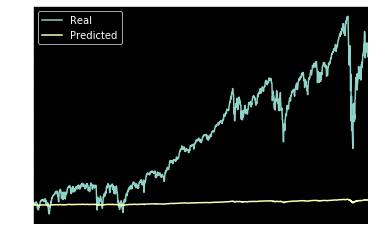

In [89]:
# Plot the real vs predicted values as a line chart
stocks.plot()

In [18]:
# Initialize Streaming DataFrame for Market Price Data Showing Backtested Signals
data_stream = Stream()
data = all_returns_df['S&P 500 close']
data_stream_df = DataFrame(data_stream, example=data)
# Initialize Streaming DataFrame for Signals
signals_stream = Stream()
signals_data=trading_signals_df
signals_stream_df = DataFrame(signals_stream, example=signals_data)

NameError: name 'Stream' is not defined

In [78]:
#Plot EMA Signals Alone Against SP500 Price
# Visualize exit position relative to close price
exit = EMA_signal_df[EMA_signal_df['EMA Entry/Exit'] == -1.0]['S&P 500 close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = EMA_signal_df[EMA_signal_df['EMA Entry/Exit'] == 1.0]['S&P 500 close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = EMA_signal_df[['S&P 500 close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = EMA_signal_df[['EWM50', 'EWM100']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I                            :Curve   [date]   (S&P 500 close)
   .NdOverlay.I                        :NdOverlay   [Variable]
      :Curve   [date]   (value)
   .Scatter.S_ampersand_P_500_close.I  :Scatter   [date]   (S&P 500 close)
   .Scatter.S_ampersand_P_500_close.II :Scatter   [date]   (S&P 500 close)

In [79]:
#Plot Sentiment Signals Alone Against SP500 Price
# Visualize exit position relative to close price
exit = trading_signals_df[trading_signals_df['Sentiment Entry/Exit'] == -1.0]['S&P 500 close'].hvplot.scatter(
    color='red',
    marker='*',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = trading_signals_df[trading_signals_df['Sentiment Entry/Exit'] == 1.0]['S&P 500 close'].hvplot.scatter(
    color='green',
    marker='*',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = trading_signals_df[['S&P 500 close']].hvplot(
    line_color='black',
    ylabel='Price in $',
    width=1000,
    height=400
)
# Overlay plots
entry_exit_plot = security_close * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I                            :Curve   [index]   (S&P 500 close)
   .Scatter.S_ampersand_P_500_close.I  :Scatter   [index]   (S&P 500 close)
   .Scatter.S_ampersand_P_500_close.II :Scatter   [index]   (S&P 500 close)

In [80]:
#Plot Case Count Signals Alone Against SP500 Price
# Visualize exit position relative to close price
exit = trading_signals_df[trading_signals_df['Case Entry/Exit'] == -1.0]['S&P 500 close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = trading_signals_df[trading_signals_df['Case Entry/Exit'] == 1.0]['S&P 500 close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = trading_signals_df[['S&P 500 close']].hvplot(
    line_color='black',
    ylabel='Price in $',
    width=1000,
    height=400
)
# Overlay plots
entry_exit_plot = security_close * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I                            :Curve   [index]   (S&P 500 close)
   .Scatter.S_ampersand_P_500_close.I  :Scatter   [index]   (S&P 500 close)
   .Scatter.S_ampersand_P_500_close.II :Scatter   [index]   (S&P 500 close)

In [81]:
#Plot Overal Signal Against SP500 Price
# Visualize exit position relative to close price
exit = trading_signals_df[trading_signals_df['Overall Entry/Exit'] == -1.0]['S&P 500 close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = trading_signals_df[trading_signals_df['Overall Entry/Exit'] == 1.0]['S&P 500 close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = trading_signals_df[['S&P 500 close']].hvplot(
    line_color='black',
    ylabel='Price in $',
    width=1000,
    height=400
)
# Overlay plots
entry_exit_plot = security_close * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I                            :Curve   [index]   (S&P 500 close)
   .Scatter.S_ampersand_P_500_close.I  :Scatter   [index]   (S&P 500 close)
   .Scatter.S_ampersand_P_500_close.II :Scatter   [index]   (S&P 500 close)

In [82]:
##Dashboard
live_column = pn.Column()

backtesting_column = pn.Column()

covid_column = pn.Column(
    "## Covid Cases in United States and Covid Sentiment",
    #covid_case_count(case_count_df),
    #covid_sentiment(newsapi)
    )

sp500_column = pn.Column(
    "## S&P 500 Data with ",
    #get_EMA(all_returns_df),
    entry_exit_plot.opts(xaxis=None)
    )

trading_dashboard = pn.Tabs(
    ('Algo Trading Bot', live_column),
    ('Back Testing', backtesting_column),
    ('COVID', covid_column),
    ('S&P 500 Signals', sp500_column)
)

In [83]:
trading_dashboard.servable()

Tabs
    [0] Column()
    [1] Column()
    [2] Column
        [0] Markdown(str)
    [3] Column
        [0] Markdown(str)
        [1] HoloViews(Overlay)